# Setup

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from typing import List

In [2]:
plt.rcParams["font.family"] ="NanumGothic"
plt.rcParams["axes.unicode_minus"] =False

In [3]:
# Logger config
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [4]:
train_df = pd.read_csv("./input/processed/train_df_imputed.csv")
test_df = pd.read_csv("./input/processed/test_df_imputed.csv")
station_info_processed = pd.read_csv("./input/processed/station_info_processed.csv")

In [5]:
train_df.head()

,id,station,station_name,date,cloud_cover_0,cloud_cover_1,cloud_cover_10,cloud_cover_11,cloud_cover_12,cloud_cover_13,...,wind_speed_23,wind_speed_3,wind_speed_4,wind_speed_5,wind_speed_6,wind_speed_7,wind_speed_8,wind_speed_9,climatology_temp,target
0,0,98,동두천,01-01,0.0,0.0,9.0,0.0,3.0,3.0,...,2.3,0.6,0.3,0.7,0.6,0.7,0.8,0.1,-2.707143,-3.992857
1,1,98,동두천,01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7,0.2,0.0,1.1,1.3,0.5,0.9,0.4,-3.646429,-1.653571
2,2,98,동두천,01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,1.5,0.8,0.8,0.9,1.0,1.1,0.1,-2.694643,-0.005357
3,3,98,동두천,01-04,0.0,0.0,2.0,0.0,0.0,1.0,...,0.9,0.3,0.5,0.2,0.5,1.3,0.5,0.2,-2.501786,-0.898214
4,4,98,동두천,01-05,0.0,0.0,0.0,0.0,0.0,0.0,...,1.4,1.1,1.6,1.4,1.8,0.5,1.1,0.6,-2.625000,-1.775000


## Helper Functions

In [6]:
def pipe(df, func, *args, **kwargs):
    """Allows df.pipe(func, *args, **kwargs) for our custom funcs."""
    return func(df, *args, **kwargs)

In [7]:
def extract_time_feature_bases(df: pd.DataFrame) -> List[str]:
    time_cols = [col for col in df.columns if re.match(r".+_\d{1,2}$", col)]
    return sorted({col.rsplit("_", 1)[0] for col in time_cols})


In [8]:
def check_nan(df: pd.DataFrame) -> int:
    return df.isna().sum().sum()

# Feature Engineering

In [9]:
def merge_with_station_data(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    output = output.merge(station_df, on='station', how='left')
    # output = output.drop(columns=['station', 'station_name'])

    return output

In [10]:
def date_column_handler(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    if df['date'].dtype == object:
        output['date'] = pd.to_datetime('2024-' + df['date'], format='%Y-%m-%d', errors='coerce')

    output['month'] = output['date'].dt.month

    doy = output['date'].dt.dayofyear
    output['doy_sin'] = np.sin(2 * np.pi * doy / 365)
    output['doy_cos'] = np.cos(2 * np.pi * doy / 365)
    output['day_of_year'] = doy

    # Day length estimation
    δ = np.deg2rad(23.44) * np.sin(2 * np.pi * (doy - 81) / 365.0)
    φ = np.deg2rad(output['lat'].values)
    ω0 = np.arccos(-np.tan(φ) * np.tan(δ))
    output['day_length'] = 2 * ω0 * (180.0/np.pi) / 15.0

    return output.drop(columns=['date'])

In [11]:
def engineer_dew_humidity_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    dew_cols = [f'dew_point_{h}' for h in range(24)]
    hum_cols = [f'humidity_{h}' for h in range(24)]

    if set(dew_cols).issubset(output.columns) and set(hum_cols).issubset(output.columns):
        output['dew_point_avg'] = output[dew_cols].mean(axis=1)
        output['humidity_avg'] = output[hum_cols].mean(axis=1)
        output['dew_point_range'] = output[dew_cols].max(axis=1) - output[dew_cols].min(axis=1)
        output['humidity_range'] = output[hum_cols].max(axis=1) - output[hum_cols].min(axis=1)
        output['dew_humidity_interaction'] = output['dew_point_avg'] * output['humidity_avg']

        # Diurnal clusters
        periods = {
            "night": range(0, 6),
            "morning": range(6, 12),
            "afternoon": range(12, 18),
            "evening": range(18, 24)
        }

        for name, hours in periods.items():
            dew_segment = output[[f'dew_point_{h}' for h in hours]]
            hum_segment = output[[f'humidity_{h}' for h in hours]]
            output[f'dew_point_{name}_avg'] = dew_segment.mean(axis=1)
            output[f'humidity_{name}_avg'] = hum_segment.mean(axis=1)
            output[f'dew_hum_{name}_interaction'] = output[f'dew_point_{name}_avg'] * output[f'humidity_{name}_avg']

    return output

In [12]:
def engineer_surface_temp_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    st_cols = [f"surface_temp_{i}" for i in range(24)]
    dp_cols = [f"dew_point_{i}" for i in range(24)]

    if not set(st_cols + dp_cols).issubset(output.columns):
        return output

    arr_t = output[st_cols].values
    arr_dp = output[dp_cols].values

    output["surface_temp_avg"] = arr_t.mean(axis=1)
    if "climatology_temp" in output.columns:
        output["surface_temp_anomaly"] = output["surface_temp_avg"] - output["climatology_temp"]

    periods = {
        "night": slice(0, 6),
        "morning": slice(6, 12),
        "afternoon": slice(12, 18),
        "evening": slice(18, 24)
    }
    for name, sl in periods.items():
        t = arr_t[:, sl].mean(axis=1)
        d = arr_dp[:, sl].mean(axis=1)
        output[f"temp_{name}_avg"] = t
        output[f"dp_{name}_avg"] = d
        output[f"dew_depression_{name}"] = t - d

    output["temp_evening_minus_morning"] = output["temp_evening_avg"] - output["temp_morning_avg"]

    return output

In [13]:
def engineer_pressure_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    slp_cols = [f'sea_level_pressure_{h}' for h in range(24)]

    if not set(slp_cols).issubset(output.columns):
        return output

    slp = output[slp_cols]
    output['slp_avg'] = slp.mean(axis=1)
    output['slp_std'] = slp.std(axis=1)
    output['pressure_tendency'] = slp.iloc[:, -1] - slp.iloc[:, 0]

    # Diurnal pressure segments
    periods = {
        "night": range(0, 6),
        "morning": range(6, 12),
        "afternoon": range(12, 18),
        "evening": range(18, 24)
    }
    for name, hours in periods.items():
        output[f'slp_{name}_avg'] = output[[f'sea_level_pressure_{h}' for h in hours]].mean(axis=1)
        output[f'slp_{name}_range'] = (
                output[[f'sea_level_pressure_{h}' for h in hours]].max(axis=1) -
                output[[f'sea_level_pressure_{h}' for h in hours]].min(axis=1)
        )

    return output

In [14]:
def engineer_wind_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    spd_cols = [f'wind_speed_{h}' for h in range(24)]

    if set(spd_cols).issubset(output.columns):
        output['wind_speed_avg'] = output[spd_cols].mean(axis=1)

        # Diurnal clusters
        periods = {
            "night": range(0, 6),
            "morning": range(6, 12),
            "afternoon": range(12, 18),
            "evening": range(18, 24)
        }

        for name, hours in periods.items():
            segment = output[[f'wind_speed_{h}' for h in hours]]
            output[f'wind_speed_{name}_avg'] = segment.mean(axis=1)

    return output

In [15]:
def engineer_cloud_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    h_cols = [f'min_cloud_height_{h}' for h in range(24)]
    c_cols = [f'cloud_cover_{h}' for h in range(24)]

    if set(h_cols).issubset(output.columns):
        output['min_cloud_h_avg'] = output[h_cols].mean(axis=1)

    if set(c_cols).issubset(output.columns):
        output['cloud_cover_avg'] = output[c_cols].mean(axis=1)

        periods = {
            "night": range(0, 6),
            "morning": range(6, 12),
            "afternoon": range(12, 18),
            "evening": range(18, 24)
        }

        for name, hours in periods.items():
            segment = output[[f'cloud_cover_{h}' for h in hours]]
            output[f'cloud_cover_{name}_avg'] = segment.mean(axis=1)
            output[f'cloud_cover_{name}_var'] = segment.var(axis=1)

    return output

In [16]:
def engineer_percip_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    precip_cols = [f'precipitation_{h}' for h in range(24)]

    if not set(precip_cols).issubset(output.columns):
        return output

    precip = output[precip_cols]
    rain_thresh = 0.01
    raining_hours = (precip > rain_thresh).sum(axis=1)

    output['precip_total_24hr'] = precip.sum(axis=1)
    output['precip_hours_raining'] = raining_hours

    periods = {
        "night": range(0, 6),
        "morning": range(6, 12),
        "afternoon": range(12, 18),
        "evening": range(18, 24)
    }

    for name, hours in periods.items():
        segment = output[[f'precipitation_{h}' for h in hours]]
        output[f'precip_total_{name}'] = segment.sum(axis=1)
        output[f'precip_hours_raining_{name}'] = (segment > rain_thresh).sum(axis=1)

    return output

In [17]:
def engineer_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    epsilon = 1e-6

    # --- Residual context ---
    output['residual_anomaly'] = output['surface_temp_anomaly'] - output['climatology_temp']
    output['scaled_residual_anomaly'] = output['residual_anomaly'] / (output['climatology_temp'].abs() + epsilon)

    # --- Diurnal delta + asymmetry ---
    output['temp_evening_minus_morning'] = output['temp_evening_avg'] - output['temp_morning_avg']
    output['diurnal_drop_ratio'] = (
            (output['temp_evening_avg'] - output['temp_night_avg']) /
            (output['temp_afternoon_avg'] - output['temp_morning_avg'] + epsilon)
    )
    output['evening_minus_afternoon_dewhum'] = (
            output['dew_hum_evening_interaction'] -
            output['dew_point_afternoon_avg'] * output['humidity_afternoon_avg']
    )
    output['dew_shift_ratio'] = output['dew_point_evening_avg'] / (output['dew_point_morning_avg'] + epsilon)
    output['afternoon_night_slope'] = (
                                              output['temp_afternoon_avg'] - output['temp_night_avg']
                                      ) / (output['slp_afternoon_avg'] - output['slp_night_avg'] + epsilon)

    # --- Spatial + pressure modulation ---
    output['lat_season_residual'] = output['lat'] * output['surface_temp_anomaly']
    output['lat_season_residual_x_slp_avg'] = output['lat_season_residual'] * output['slp_afternoon_avg']
    output['lat_season_x_slp_sq'] = output['lat_season_residual'] * (output['slp_afternoon_avg'] ** 2)
    output['dropratio_X_lat_season'] = output['diurnal_drop_ratio'] * output['lat_season_residual']

    # --- Moisture stress (evening focus) ---
    output['humidity_avg_x_dew_depression_evening'] = output['humidity_evening_avg'] * output['dew_depression_evening']
    output['humidity_avg_x_dew_depression_evening_sq'] = output['humidity_avg_x_dew_depression_evening'] ** 2
    output['humidity_x_dew_evening_x_lat'] = (
            output['humidity_evening_avg'] * output['dew_depression_evening'] * output['lat']
    )
    output['dew_hum_evening_interaction'] = output['humidity_evening_avg'] * output['dew_point_evening_avg']
    output['humidity_x_dew_range'] = output['humidity_avg'] * output['dew_point_range']

    # --- Volatility-driven features ---
    output['dew_depression_chain'] = (
            output['dew_depression_morning'] * output['dew_depression_afternoon'] * output['dew_depression_evening']
    )
    output['humid_evening_x_slp_std'] = output['humidity_evening_avg'] * output['slp_std']
    output['humid_cloud_stress_alt'] = (
            output['humidity_evening_avg'] * output['cloud_cover_evening_avg'] /
            (output['pressure_tendency'].abs() + epsilon)
    )
    output['humidity_cloud_dew_combo'] = (
            output['humidity_evening_avg'] * output['cloud_cover_evening_avg'] * output['dew_point_evening_avg']
    )

    # --- Seasonal positioning ---
    output['dew_evening_x_doy'] = output['dew_point_evening_avg'] * output['day_of_year']
    output['climatology_temp_x_doy_sin'] = output['climatology_temp'] * output['doy_sin']
    output['climatology_temp_x_doy_cos'] = output['climatology_temp'] * output['doy_cos']

    # --- Station + month anomaly normalization ---
    group_mean = output.groupby(['station', 'month'])['residual_anomaly'].mean().rename('station_month_anomaly_mean')
    output = output.merge(group_mean, on=['station', 'month'], how='left')
    output['station_month_anomaly_centered'] = output['residual_anomaly'] - output['station_month_anomaly_mean']

    output['station_norm_anomaly_x_humidity'] = output['scaled_residual_anomaly'] * output['humidity_evening_avg']
    output['dp_morning_x_climatology'] = output['dp_morning_avg'] * output['climatology_temp']

    return output

In [18]:
def drop_unused_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Drop {prefix}_{n}(original) features
    prefixes = extract_time_feature_bases(output)
    drop_cols = [f"{p}_{h}" for p in prefixes for h in range(24)]
    output = output.drop(columns=[col for col in drop_cols if col in output.columns], errors='ignore')

    # Drop unused identifiers
    output = output.drop(columns=['station', 'station_name', 'month'], errors='ignore')

    # Prune low-SHAP base features
    # drop_low_shap = [
    #     'slp_night_range', 'dew_point_night_avg', 'min_cloud_h_avg', 'slp_evening_range',
    #     'slp_morning_avg', 'slp_std', 'precip_total_evening', 'dew_point_morning_avg',
    #     'dew_humidity_interaction', 'wind_speed_night_avg', 'slp_evening_avg',
    #     'dew_point_avg', 'dew_point_range', 'cloud_cover_evening_avg',
    #     'cloud_cover_morning_var', 'climatology_temp', 'wind_speed_morning_avg',
    #     'cloud_cover_afternoon_var', 'dew_point_afternoon_avg',
    #     'dew_hum_morning_interaction', 'cloud_cover_evening_var', 'precip_total_night',
    #     'slp_night_avg', 'humidity_morning_avg', 'slp_afternoon_range',
    #     'wind_speed_avg', 'humidity_night_avg', 'temp_morning_avg',
    #     'dew_hum_night_interaction', 'humidity_range', 'precip_total_24hr',
    #     'cloud_cover_avg', 'slp_avg', 'surface_temp_avg', 'precip_total_afternoon',
    #     'doy_cos', 'precip_hours_raining', 'cloud_cover_morning_avg',
    #     'precip_hours_raining_evening', 'cloud_cover_night_var',
    #     'cloud_cover_night_avg', 'dew_depression_morning', 'dp_morning_avg',
    #     'precip_hours_raining_morning', 'dp_afternoon_avg', 'dp_evening_avg',
    #     'precip_hours_raining_afternoon', 'dp_night_avg', 'precip_hours_raining_night'
    # ]
    # output = output.drop(columns=[col for col in drop_low_shap if col in output.columns], errors='ignore')

    return output

In [19]:
def engineer_features(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    return (
        output
        .pipe(merge_with_station_data, station_df)
        .pipe(date_column_handler)
        .pipe(engineer_dew_humidity_features)
        .pipe(engineer_surface_temp_features)
        .pipe(engineer_pressure_features)
        .pipe(engineer_wind_features)
        .pipe(engineer_cloud_features)
        .pipe(engineer_percip_features)
        .pipe(engineer_interaction_features)
        .pipe(drop_unused_features)
    )

In [20]:
train_df = engineer_features(train_df, station_info_processed)
test_df = engineer_features(test_df, station_info_processed)

In [21]:
train_df.shape

(13132, 103)

In [22]:
test_df.shape

(3004, 102)

In [23]:
train_df

,id,climatology_temp,target,elev,lat,lon,doy_sin,doy_cos,day_of_year,day_length,...,humid_evening_x_slp_std,humid_cloud_stress_alt,humidity_cloud_dew_combo,dew_evening_x_doy,climatology_temp_x_doy_sin,climatology_temp_x_doy_cos,station_month_anomaly_mean,station_month_anomaly_centered,station_norm_anomaly_x_humidity,dp_morning_x_climatology
0,0,-2.707143,-3.992857,115.62,37.9019,127.0607,1.721336e-02,0.999852,1,9.426812,...,65.252515,0.000000,-0.000000,-17.183333,-4.659901e-02,-2.706742,2.505358,-2.674406,-2.435355,45.209286
1,1,-3.646429,-1.653571,115.62,37.9019,127.0607,3.442161e-02,0.999407,2,9.437325,...,48.571459,0.000000,-0.000000,-34.066667,-1.255159e-01,-3.644268,2.505358,-0.975001,17.277093,60.530714
2,2,-2.694643,-0.005357,115.62,37.9019,127.0607,5.161967e-02,0.998667,3,9.448699,...,32.524114,0.000000,-0.000000,-55.650000,-1.390966e-01,-2.691050,2.505358,-2.436906,0.812900,42.260982
3,3,-2.501786,-0.898214,115.62,37.9019,127.0607,6.880243e-02,0.997630,4,9.460926,...,212.122251,13.090675,-637.777778,-22.400000,-1.721289e-01,-2.495857,2.505358,-1.422620,29.573705,36.776250
4,4,-2.625000,-1.775000,115.62,37.9019,127.0607,8.596480e-02,0.996298,5,9.473997,...,23.072707,0.000000,-0.000000,-100.333333,-2.256576e-01,-2.615283,2.505358,-0.647025,19.704225,38.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,17506,-3.485714,0.785714,80.09,37.2640,127.4842,-6.880243e-02,0.997630,361,9.449241,...,76.189075,0.000000,-0.000000,-3483.650000,2.398256e-01,-3.477454,2.517986,4.332609,112.351601,13.768571
13128,17507,-2.632143,-0.367857,80.09,37.2640,127.4842,-5.161967e-02,0.998667,362,9.455193,...,137.097627,40.277767,-1246.194444,-2871.866667,1.358703e-01,-2.628634,2.517986,1.671300,100.004711,35.270714
13129,17508,-1.555357,1.055357,80.09,37.2640,127.4842,-3.442161e-02,0.999407,363,9.462014,...,54.049457,14.148139,-190.646296,-3260.950000,5.353790e-02,-1.554435,2.517986,-0.723938,73.437126,22.993363
13130,17509,-2.814286,6.614286,80.09,37.2640,127.4842,-1.721336e-02,0.999852,364,9.469701,...,79.281498,192.163642,-1472.614815,-1468.133333,4.844330e-02,-2.813869,2.517986,2.443919,124.593300,18.621190


In [24]:
test_df

,id,climatology_temp,elev,lat,lon,doy_sin,doy_cos,day_of_year,day_length,dew_point_avg,...,humid_evening_x_slp_std,humid_cloud_stress_alt,humidity_cloud_dew_combo,dew_evening_x_doy,climatology_temp_x_doy_sin,climatology_temp_x_doy_cos,station_month_anomaly_mean,station_month_anomaly_centered,station_norm_anomaly_x_humidity,dp_morning_x_climatology
0,0,24.017857,39.81,37.2575,126.9830,-0.835925,-0.548843,240,12.946233,21.679167,...,79.953334,9.487176,525.400000,5112.000000,-20.077139,-13.182032,-23.447901,2.024686,-66.005797,505.976190
1,1,1.778571,30.59,37.8859,126.7665,-0.523416,0.852078,333,9.580320,-5.075000,...,130.544650,60.289842,-1141.688889,-1370.850000,-0.930932,1.515481,-6.780505,3.610862,-123.560841,-10.167500
2,2,24.091071,30.59,37.8859,126.7665,-0.111659,-0.993747,189,14.503336,22.141667,...,127.603186,177.065140,9767.212500,4532.850000,-2.689985,-23.940420,-22.563864,1.660887,-78.523667,512.738304
3,3,27.076786,30.59,37.8859,126.7665,-0.693281,-0.720667,227,13.466553,25.683333,...,75.966070,2442.904452,12068.008333,5606.900000,-18.771827,-19.513350,-23.165052,2.565647,-67.582384,703.093869
4,4,7.417857,30.59,37.8859,126.7665,0.970064,0.242850,77,11.832631,-2.470833,...,68.304750,0.000000,-0.000000,-55.183333,7.195796,1.801425,-7.588670,1.477956,-51.761107,-23.737143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,2999,1.932143,39.81,37.2575,126.9830,-0.463550,0.886071,337,9.569618,-7.950000,...,69.882750,13.697912,-376.236111,-2892.583333,-0.895645,1.712015,2.492751,-3.515370,-23.199516,-14.491071
3000,3000,12.312500,30.59,37.8859,126.7665,0.999917,-0.012910,92,12.458907,-6.066667,...,67.631130,302.776769,-328.513889,-332.733333,12.311474,-0.158958,-10.677511,-7.364155,-79.859554,-75.311458
3001,3001,27.073214,39.81,37.2575,126.9830,-0.393590,-0.919286,206,14.094582,18.466667,...,69.246143,722.498796,8460.475000,4020.433333,-10.655754,-24.888026,-23.919700,-8.376729,-91.259082,470.622708
3002,3002,18.208929,39.81,37.2575,126.9830,0.642055,-0.766659,142,14.182867,14.370833,...,91.243387,0.000000,0.000000,2132.366667,11.691128,-13.960036,-14.148560,2.793203,-47.706529,268.885179


<Axes: >

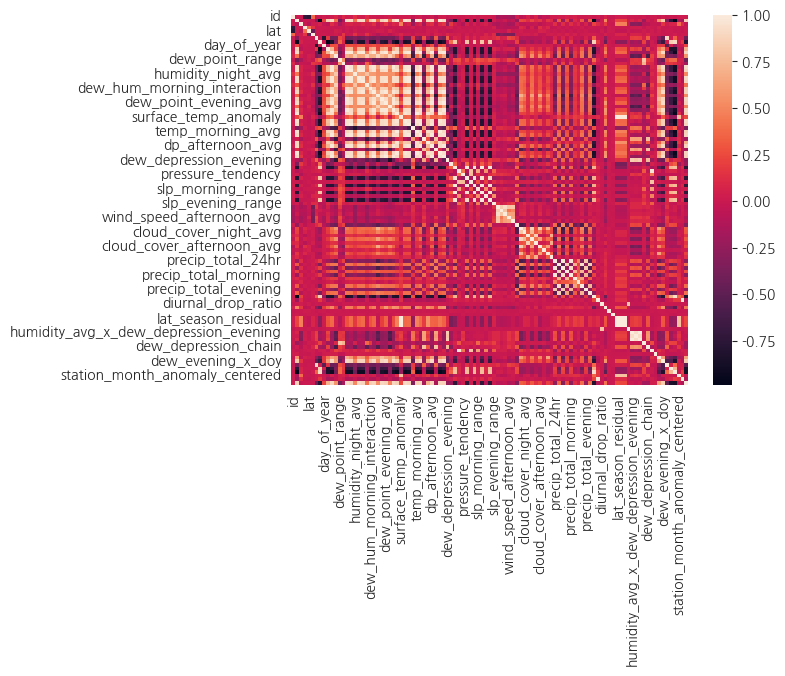

In [25]:
corr = train_df.corr()
sns.heatmap(corr)

> Export

In [26]:
# export df
train_df.to_csv("./input/processed/train_df_final_v5.csv", index=False)
test_df.to_csv("./input/processed/test_df_final_v5.csv", index=False)